In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, time

%matplotlib inline

In [3]:
caminho_parquet = "data//RIOFER_PICKING_SGD.parquet"

df = pd.read_parquet(caminho_parquet)

df.head(10)

,AbsEntry,CardCode,CardName,BaseObject,ItemCode,ItemName,SWeight1,UomCode,RelQtty,U_TU_QuemEntrega,...,U_SPS_Longitude,U_GI_Rua,U_GI_NumRua,U_GI_Complemento,U_GI_Bairro,U_GI_Cidade,U_GI_Estado,U_GI_Cep,ShipDate,Localizacao
0,91552,C0028056,CARLOS EDUARDO OLIVEIRA CRUVINEL,17,PA00662,METALON PA 1.20 - 30 X 20 6MT,5.550000,BARRA,52.0,01,...,-50.9008171/-17.8511513,402,0.0,QD 25 LT 10,ZONA RURAL,RIO VERDE,GO,75911040,2025-06-30,G1 - B
1,91552,C0028056,CARLOS EDUARDO OLIVEIRA CRUVINEL,17,PA00660,METALON PA 1.20 - 20 X 20 6MT,4.360000,BARRA,6.0,01,...,-50.9008171/-17.8511513,402,0.0,QD 25 LT 10,ZONA RURAL,RIO VERDE,GO,75911040,2025-06-30,G1 - B
2,96641,C001107,RIOFER INDUSTRIAL LTDA,17,PA00158,"VERGALHÃO DOB-R 5,00MM CA60 12MT",1.800000,BARRA,1.0,00,...,None,None,NaN,None,None,None,None,None,NaT,G2
3,96641,C020504,JORGE LUIZ DA SILVA,17,PA00293,PERFIL_CE TRILHO U 2.00 - 55 X 40 3MT,6.110000,BARRA,1.0,01,...,None,MARIA MERCEDES FERREIRA,NaN,QD 19 LT 26,BLANDINA,SANTA HELENA DE GOIAS,GO,75920000,2025-05-12,G1 - C
4,100299,C0020909,ACM ENGENHARIA LTDA,17,PA00029,PERFIL U 200X50 #13 6MT CIVIL 300,31.309999,BARRA,1.0,01,...,None,TOBIAS DO RESTAURANTE,0.0,QD 10 LT 6,DIMPE,RIO VERDE,GO,None,2025-07-07,G1 - B
5,102402,C0025303,CASA DO CALHEIRO MINEIROS LTDA,17,PA00089,CORRUGADA BANDEJA 1.20MM 320 X 6 MT,21.379999,UNIDADE,17.0,02,...,None,JOAQUIM TEODORO MARTINS,0.0,QUADRA05 LOTE 01,RESIDENCIAL SANTA MARIA,MINEIROS,GO,75835332,2025-07-26,G1 - C
6,102895,C0029256,IRMAOS CABRAL CENTER LTDA,13,RV00082,"TUBO RED IND 101,6-4"" CH 2,00 - 6 MT",30.500000,BARRA,1.0,02,...,None,RIACHUELO,3023.0,QUADRA012F LOTE 8E09,VILA FATIMA,JATAI,GO,75803050,2025-07-24,G1 - B
7,103868,C000123,COMERCIAL SARICO MATERIAIS PARA CONSTRUCAO EIR...,13,RV00278,PARAF HARD 12 14 X 3/4 TELHA-TERÇA-8201 100 PC,0.500000,PACOTE,15.0,01,...,None,QUITO DO GUARANA,0.0,QD 17 LT 02,DIMPE,RIO VERDE,GO,75903060,2025-10-28,TELHA
8,103869,C000123,COMERCIAL SARICO MATERIAIS PARA CONSTRUCAO EIR...,13,RV00278,PARAF HARD 12 14 X 3/4 TELHA-TERÇA-8201 100 PC,0.500000,PACOTE,25.0,01,...,None,PAUZANES DE CARVALHO,744.0,None,SETOR PAUSANES,RIO VERDE,GO,75903060,2023-05-10,TELHA
9,104597,C0028853,SANTINHO DANIELEWZ,17,PA00319,CORRUGADA LAMBRIL 0.90MM 2 X 1.06,16.910000,BARRA,6.0,02,...,None,GO 174,0.0,SENTIDO AP DO RIO DOCE,ZONA RURAL,RIO VERDE,GO,75901970,2025-07-19,G1 - C


In [ ]:
import pandas as pd
from datetime import datetime, time
import plotly.express as px

caminho_parquet = "data//RIOFER_BEAS_GANT.parquet"
selected_date = pd.to_datetime('today').date()
selected_Maquinas = ['DBR 165']

morning_start = time(7, 0)
morning_end = time(11, 0)
afternoon_start = time(13, 0)
afternoon_end = time(18, 0)

df = pd.read_parquet(caminho_parquet)
for col in ['HoraInicial', 'HoraFim']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])

if selected_Maquinas is not None:
    df = df[df['Maquina'].isin(selected_Maquinas)]

def split_into_allowed_pieces(row, day_date):
    start = row['HoraInicial']
    end = row['HoraFim']
    day_start_dt = pd.Timestamp.combine(day_date, time(0,0))
    day_end_dt = day_start_dt + pd.Timedelta(days=1)

    if end <= day_start_dt or start >= day_end_dt:
        return []

    start = max(start, day_start_dt)
    end = min(end, day_end_dt)

    pieces = []
    periods = [
        (pd.Timestamp.combine(day_date, morning_start), pd.Timestamp.combine(day_date, morning_end)),
        (pd.Timestamp.combine(day_date, afternoon_start), pd.Timestamp.combine(day_date, afternoon_end))
    ]

    for p_start, p_end in periods:
        s = max(start, p_start)
        e = min(end, p_end)
        if s < e:
            pieces.append((s, e))
    return pieces

records = []

day_date = pd.to_datetime(selected_date).date()

for _, row in df.iterrows():
    pos = row.get('Ordem', '')
    Maquina = row.get('Maquina', 'Unknown')
    Maquina_pos = f"{Maquina} | Pos {pos}"

    pieces = split_into_allowed_pieces(row, day_date)
    for (s, e) in pieces:
        task = f"{row.get('Ordem', '')} - {row.get('Codigo', '')}"
        records.append({
            'Maquina': Maquina,
            'Ordem': pos,
            'Maquina_Pos': Maquina_pos,
            'Task': task,
            'Start': s,
            'Finish': e,
            'Ordem': row.get('Ordem'),
            'Codigo': row.get('Codigo'),
            'Descricao': row.get('Descricao'),
            'Quantidade': row.get('Quantidade')
        })

gantt_df = pd.DataFrame.from_records(records)

if gantt_df.empty:
    print(f"Nenhuma produção encontrada no dia {day_date} dentro do horário 07:00-18:00 (com pausa 11:00-13:00).")
else:
    gantt_df['Maquina'] = gantt_df['Maquina'].astype(str)
    gantt_df['Ordem'] = pd.to_numeric(gantt_df['Ordem'], errors='coerce')
    gantt_df = gantt_df.sort_values(['Maquina', 'Ordem', 'Start'])

    ordered_rows = gantt_df['Maquina_Pos'].unique().tolist()
    gantt_df['Maquina_Pos'] = pd.Categorical(gantt_df['Maquina_Pos'], categories=ordered_rows, ordered=True)

if not gantt_df.empty:
    fig = px.timeline(
        gantt_df,
        x_start='Start',
        x_end='Finish',
        y='Maquina_Pos',
        color='Ordem',
        hover_data=['Task', 'Descricao', 'Quantidade', 'Codigo'],
        title=f'Gantt de produção por máquina - {day_date}'
    )

    day_start = pd.Timestamp.combine(day_date, morning_start)
    day_end = pd.Timestamp.combine(day_date, afternoon_end)
    fig.update_layout(
        xaxis_range=[day_start, day_end],
        xaxis_title='Horário',
        yaxis_title='Máquina | Posição',
        legend_title='Ordem',
        height=max(400, 30 * len(ordered_rows))
    )

    fig.update_traces(text=gantt_df['Task'], textposition='inside')

    fig.show()


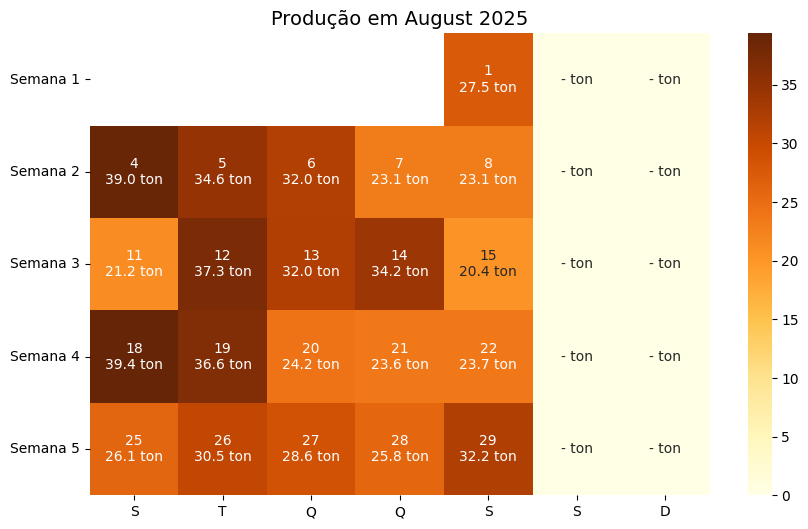

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import calendar
import seaborn as sns

ano = 2025
mes = 8
dias_mes = calendar.monthrange(ano, mes)[1]

np.random.seed(42)
producao = np.random.uniform(low=20, high=40, size=dias_mes) 

cal = calendar.monthcalendar(ano, mes)
num_weeks = len(cal)

data_matrix = np.full((num_weeks, 7), np.nan)
text_matrix = [["" for _ in range(7)] for _ in range(num_weeks)]

day = 1
for i, week in enumerate(cal):
    for j, d in enumerate(week):
        if d != 0:
            if j in [5, 6]:
                valor = 0.0
            else:
                valor = producao[day - 1]
                day += 1
            data_matrix[i, j] = valor
            if valor == 0.0 :
                text_matrix[i][j] = '- ton'
            else:
                text_matrix[i][j] = f"{d}\n{valor:.1f} ton"


plt.figure(figsize=(10, 6))
ax = sns.heatmap(data_matrix, annot=text_matrix, fmt="", cmap="YlOrBr",
                 linewidths=0, cbar=True)

ax.set_xticklabels(['S', 'T', 'Q', 'Q', 'S', 'S', 'D'])
ax.set_yticklabels([f"Semana {i+1}" for i in range(num_weeks)], rotation=0)
plt.title(f"Produção em {calendar.month_name[mes]} {ano}", fontsize=14)
plt.show()


C:\Users\carlos.eduardo\AppData\Local\Temp\ipykernel_9200\2354394370.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.01, 0.99, 0.99])


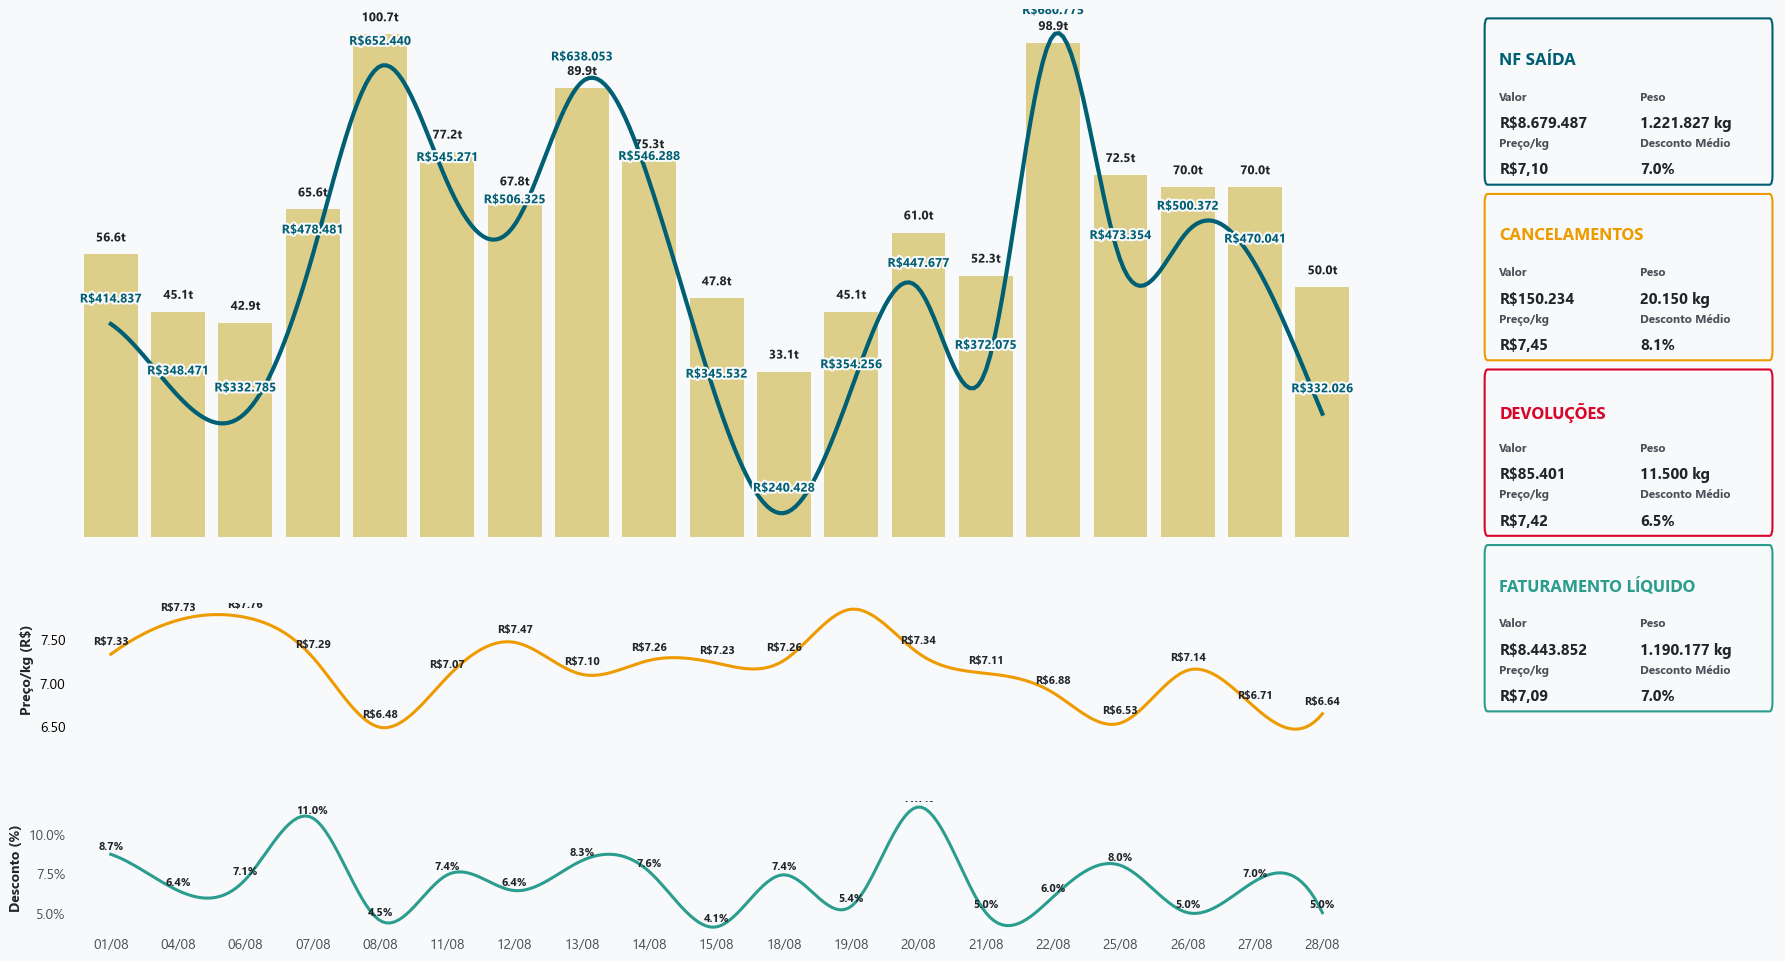

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.patheffects as pe
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import FancyBboxPatch

try:
    plt.rcParams['font.family'] = 'Segoe UI'
except:
    plt.rcParams['font.family'] = 'sans-serif'

BACKGROUND_COLOR = '#F8F9FA'
TITLE_COLOR = '#212529'
SUBTITLE_COLOR = '#495057'
PRIMARY_COLOR = '#005f73'
SECONDARY_COLOR = "#ebd774"
ACCENT_COLOR = '#ee9b00'
NEGATIVE_COLOR = '#d90429'
POSITIVE_COLOR = '#2a9d8f'
NEUTRAL_COLOR = '#fbfbfb'

# Dados de exemplo
df = pd.DataFrame({
    'Data': pd.to_datetime([
        '2025-08-01','2025-08-04','2025-08-06','2025-08-07','2025-08-08',
        '2025-08-11','2025-08-12','2025-08-13','2025-08-14','2025-08-15',
        '2025-08-18','2025-08-19','2025-08-20','2025-08-21','2025-08-22',
        '2025-08-25','2025-08-26','2025-08-27','2025-08-28'
    ]),
    'Faturado (R$)': [
        414836.92, 348470.80, 332785.03, 478481.16, 652439.73,
        545270.90, 506324.90, 638052.63, 546288.47, 345532.32, 240427.70,
        354256.24, 447676.74, 372074.68, 680775.43, 473353.99, 500372.04,
        470041, 332026.29
    ],
    'Peso (kg)': [
        56593,45105,42896,65592,100653,77167,67802,89913,75256,47813,
        33127,45114,60975,52342,98905,72477,70041,70041,50015
    ],
    'Desconto médio': [
        8.7,6.4,7.1,11.0,4.5,7.4,6.4,8.3,7.6,4.1,7.4,5.4,11.7,5,6,8,5,7,5
    ]
})
df['Preco_por_kg'] = df['Faturado (R$)'] / df['Peso (kg)']
df['Data_Label'] = df['Data'].dt.strftime('%d/%m')

x_orig = np.arange(len(df))

def fmt_currency_int(v):
    return f"R${int(round(v)):,}".replace(',', '.')

fig = plt.figure(figsize=(22, 12), facecolor=BACKGROUND_COLOR)
gs = fig.add_gridspec(3, 2, width_ratios=[4.4, 1], height_ratios=[4, 1, 1],
                      hspace=0.25, wspace=0.15)

ax1 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[2, 0], sharex=ax1)
for ax in (ax1, ax3, ax4):
    ax.set_facecolor(BACKGROUND_COLOR)

kpi_ax = fig.add_subplot(gs[:, 1])
kpi_ax.set_facecolor(BACKGROUND_COLOR)
kpi_ax.axis('off')

# ✅ Gráfico 1: Barras (Peso)
sns.barplot(x='Data_Label', y='Peso (kg)', data=df, ax=ax1, color=SECONDARY_COLOR, alpha=0.95, zorder=2)
ax1.set_ylabel(None)
ax1.tick_params(axis='y', labelleft=False, left=False)
ax1.tick_params(axis='x', labelbottom=False)
plt.setp(ax1.get_xticklabels(), visible=False)
for spine in ax1.spines.values():
    spine.set_visible(False)

# ✅ Gráfico 1: Linha (Faturado)
ax2 = ax1.twinx()
spline_faturado = make_interp_spline(x_orig, df['Faturado (R$)'])
x_smooth = np.linspace(x_orig.min(), x_orig.max(), 300)
y_smooth_faturado = spline_faturado(x_smooth)
ax2.plot(x_smooth, y_smooth_faturado, color=PRIMARY_COLOR, linewidth=3, zorder=3)
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.tick_params(axis='y', labelright=False, right=False)

# ✅ Remove marcador e texto "Data_Label"
ax1.set_xlabel('')  # Remove qualquer rótulo residual
# Nenhuma anotação de Data_Label será adicionada

# ✅ Gráfico 2: Preço/kg
spline_preco = make_interp_spline(x_orig, df['Preco_por_kg'])
ax3.plot(x_smooth, spline_preco(x_smooth), color=ACCENT_COLOR, linewidth=2.2)
ax3.set_ylabel('Preço/kg (R$)', fontsize=10, color=TITLE_COLOR, fontweight='bold')
ax3.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y:,.2f}'.replace(',', '.')))
for sp in ax3.spines.values():
    sp.set_visible(False)
plt.setp(ax3.get_xticklabels(), visible=False)
ax3.grid(axis='y', linestyle=':', alpha=0.7, color=NEUTRAL_COLOR)

# ✅ Gráfico 3: Desconto (%)
spline_desc = make_interp_spline(x_orig, df['Desconto médio'])
ax4.plot(x_smooth, spline_desc(x_smooth), color=POSITIVE_COLOR, linewidth=2.2)
ax4.set_ylabel('Desconto (%)', fontsize=10, color=TITLE_COLOR, fontweight='bold')
ax4.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y:.1f}%'))
for sp in ax4.spines.values():
    sp.set_visible(False)
ax4.tick_params(axis='y', colors=SUBTITLE_COLOR, left=False)
ax4.grid(axis='y', linestyle=':', alpha=0.7, color=NEUTRAL_COLOR)
ax4.tick_params(axis='x', colors=SUBTITLE_COLOR)

# Adiciona os textos aos gráficos
max_peso = df['Peso (kg)'].max()
ax1.set_xlim(-0.6, len(df)-0.4)
for idx, row in df.iterrows():
    ax1.text(idx, row['Peso (kg)'] + max_peso*0.02, f'{row["Peso (kg)"]/1000:.1f}t',
             ha='center', va='bottom', fontsize=9, color=TITLE_COLOR, fontweight='bold',
             path_effects=[pe.withStroke(linewidth=3, foreground=BACKGROUND_COLOR)], zorder=10, clip_on=True)
    ax2.text(idx, row['Faturado (R$)'] + df['Faturado (R$)'].max()*0.025,
             fmt_currency_int(row['Faturado (R$)']), ha='center', va='bottom',
             fontsize=9, color=PRIMARY_COLOR, fontweight='bold',
             path_effects=[pe.withStroke(linewidth=3, foreground=BACKGROUND_COLOR)], zorder=11, clip_on=True)
    ax3.text(idx, row['Preco_por_kg'] + 0.08, f'R${row["Preco_por_kg"]:,.2f}'.replace(',', '.'),
             ha='center', va='bottom', fontsize=8, color=TITLE_COLOR, fontweight='bold', clip_on=True)
    ax4.text(idx, row['Desconto médio'] + 0.15, f'{row["Desconto médio"]:.1f}%',
             ha='center', va='bottom', fontsize=8, color=TITLE_COLOR, fontweight='bold', clip_on=True)

for a in (ax1, ax2, ax3, ax4):
    try:
        a.minorticks_off()
    except Exception:
        pass
    a.tick_params(which='both', length=0)

# Lógica para os KPIs (sem alterações)
total_faturado = df['Faturado (R$)'].sum()
peso_total = df['Peso (kg)'].sum()
preco_medio_kg = total_faturado / peso_total
desconto_ponderado = (df['Desconto médio'] * df['Faturado (R$)']).sum() / df['Faturado (R$)'].sum()
kpi_groups = {
    'NF SAÍDA': {
        'Valor': total_faturado, 'Peso': peso_total,
        'Preço/kg': preco_medio_kg, 'Desconto Médio': desconto_ponderado,
        'color': PRIMARY_COLOR
    },
    'CANCELAMENTOS': {
        'Valor': 150234.50, 'Peso': 20150,
        'Preço/kg': 7.45, 'Desconto Médio': 8.1,
        'color': ACCENT_COLOR
    },
    'DEVOLUÇÕES': {
        'Valor': 85400.75, 'Peso': 11500,
        'Preço/kg': 7.42, 'Desconto Médio': 6.5,
        'color': NEGATIVE_COLOR
    }
}
valor_liquido = kpi_groups['NF SAÍDA']['Valor'] - kpi_groups['CANCELAMENTOS']['Valor'] - kpi_groups['DEVOLUÇÕES']['Valor']
peso_liquido = kpi_groups['NF SAÍDA']['Peso'] - kpi_groups['CANCELAMENTOS']['Peso'] - kpi_groups['DEVOLUÇÕES']['Peso']
preco_kg_liquido = valor_liquido / peso_liquido if peso_liquido > 0 else 0
valor_desc_nfe = kpi_groups['NF SAÍDA']['Valor'] * kpi_groups['NF SAÍDA']['Desconto Médio']
valor_desc_canc = kpi_groups['CANCELAMENTOS']['Valor'] * kpi_groups['CANCELAMENTOS']['Desconto Médio']
valor_desc_dev = kpi_groups['DEVOLUÇÕES']['Valor'] * kpi_groups['DEVOLUÇÕES']['Desconto Médio']
desconto_medio_liquido = (valor_desc_nfe - valor_desc_canc - valor_desc_dev) / valor_liquido if valor_liquido > 0 else 0
kpi_total = {
    'FATURAMENTO LÍQUIDO': {
        'Valor': valor_liquido, 'Peso': peso_liquido,
        'Preço/kg': preco_kg_liquido, 'Desconto Médio': desconto_medio_liquido,
        'color': POSITIVE_COLOR
    }
}

# Desenha os boxes dos KPIs (sem alterações)
box_h = 0.16
box_w = 0.96
spacing = 0.03
top_start = 0.98
x_pos = 0.02
all_kpis_to_plot = {**kpi_groups, **kpi_total}

for i, (title, data) in enumerate(all_kpis_to_plot.items()):
    y_pos = top_start - i * (box_h + spacing)
    box = FancyBboxPatch((x_pos, y_pos - box_h), box_w, box_h,
                         boxstyle="round,pad=0.01,rounding_size=0.01",
                         linewidth=1.5, edgecolor=data['color'], facecolor=BACKGROUND_COLOR,
                         transform=kpi_ax.transAxes, zorder=20)
    kpi_ax.add_patch(box)
    kpi_ax.text(x_pos + 0.04, y_pos - 0.025, title,
                transform=kpi_ax.transAxes, fontsize=12, color=data['color'],
                weight='bold', zorder=21, va='top', ha='left')
    sub_kpi_y_base = y_pos - 0.075
    sub_kpi_positions = {
        'Valor': (x_pos + 0.04, sub_kpi_y_base),
        'Peso': (x_pos + 0.52, sub_kpi_y_base),
        'Preço/kg': (x_pos + 0.04, sub_kpi_y_base - 0.05),
        'Desconto Médio': (x_pos + 0.52, sub_kpi_y_base - 0.05),
    }
    formatted_values = {
        'Valor': fmt_currency_int(data['Valor']),
        'Peso': f"{int(data['Peso']):,} kg".replace(',', '.'),
        'Preço/kg': f"R${data['Preço/kg']:.2f}".replace('.', ','),
        'Desconto Médio': f"{data['Desconto Médio']:.1f}%"
    }
    for label, pos in sub_kpi_positions.items():
        kpi_ax.text(pos[0], pos[1], label, transform=kpi_ax.transAxes,
                    fontsize=8.5, color=SUBTITLE_COLOR, weight='bold', zorder=21,
                    va='center', ha='left')
        kpi_ax.text(pos[0], pos[1] - 0.02, formatted_values[label], transform=kpi_ax.transAxes,
                    fontsize=11, color=TITLE_COLOR, weight='bold', zorder=21,
                    va='top', ha='left')

fig.tight_layout(rect=[0, 0.01, 0.99, 0.99])
plt.show()